# 第7章: 機械学習

本章では、[Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されているSSTデータセットを用いる。


## 60. データの入手・整形

GLUEのウェブサイトから[SST-2](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip)データセットを取得せよ。学習データ（`train.tsv`）と検証データ（`dev.tsv`）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [1]:
import os
import zipfile
import requests

# データセットのダウンロード
url = "https://dl.fbaipublicfiles.com/glue/data/SST-2.zip"
zip_path = "./data/SST-2.zip"

response = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(response.content)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("./data")

In [2]:
train_path = "./data/SST-2/train.tsv"
dev_path = "./data/SST-2/dev.tsv"

def count_labels(filepath):
    with open(filepath, "r")as f:
        lines = f.readlines()
        count_positive = 0
        count_negative = 0
        
        for line in lines[1:]:
            label = line.split("\t")[1].strip()
            if label == "0":
                count_negative += 1
            elif label == "1":
                count_positive += 1
                
        return f"Positive: {count_positive}, Negative: {count_negative}"

print("Train set => " + count_labels(train_path))
print("Dev set => " + count_labels(dev_path))

Train set => Positive: 37569, Negative: 29780
Dev set => Positive: 444, Negative: 428


## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（`train.tsv`）および検証データ（`dev.tsv`）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、"too loud , too goofy"というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの"too loud , too goofy"に対してラベル"0"（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [3]:
import pandas as pd
from collections import Counter

def load_data(filepath):
    df = pd.read_csv(filepath, sep="\t", header=0)
    df.columns = ["text", "label"]
    df["label"] = df["label"].astype(int)
    return df

def make_BoW_dict(df_dataset):
    result = []
    for text, label in zip(df_dataset["text"], df_dataset["label"]):
        if not isinstance(text, str) or text.strip() == "":
            continue
        tokens = text.split()
        feature = dict(Counter(tokens))
        result.append({"text": text, "label": label, "feature": feature})
    return result

train_data = make_BoW_dict(load_data(train_path))
dev_data = make_BoW_dict(load_data(dev_path))

print(train_data[0])

{'text': 'hide new secretions from the parental units ', 'label': 0, 'feature': {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1}}


## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# BoW辞書をベクトル化
vectorizer = DictVectorizer(sparse=True)
X_train = vectorizer.fit_transform([item["feature"] for item in train_data])
y_train = [item["label"] for item in train_data]

# モデル学習
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [5]:
# 検証データのベクトル化
X_dev = vectorizer.transform([item["feature"] for item in dev_data])
y_dev = [item["label"] for item in dev_data]

# 先頭の事例の予測
pred_label = model.predict(X_dev[0])

print("予測ラベル:", pred_label[0])
print("正解ラベル:", y_dev[0])

予測ラベル: 1
正解ラベル: 1


## 64. 条件付き確率

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。

In [6]:
proba = model.predict_proba(X_dev[0])
print(proba[0])

[0.00432436 0.99567564]


## 65. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして"the worst movie I 've ever seen"を与え、ロジスティック回帰モデルの予測結果を確認せよ。


In [7]:
def predict(text):
    # テキストをBoW辞書に変換
    feature = dict(Counter(text.split()))
    text_vector = vectorizer.transform([feature])
    
    # 予測ラベルと確率を取得
    pred_label = model.predict(text_vector)[0]
    pred_proba = model.predict_proba(text_vector)[0]
    
    # 出力
    sentiment = "Positive" if pred_label == 1 else "Negative"
    confidence = pred_proba[pred_label]
    
    print(f"Prediction: {sentiment} (confidence: {confidence:.4f})")
    
    return {
        "sentiment": sentiment,
        "confidence": confidence,
        "probabilities": {
            "negative": pred_proba[0],
            "positive": pred_proba[1]
        }
    }

result = predict("the worst movie I 've ever seen")
print(result)

Prediction: Negative (confidence: 0.9773)
{'sentiment': 'Negative', 'confidence': 0.977306623382768, 'probabilities': {'negative': 0.977306623382768, 'positive': 0.022693376617232027}}


## 66. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

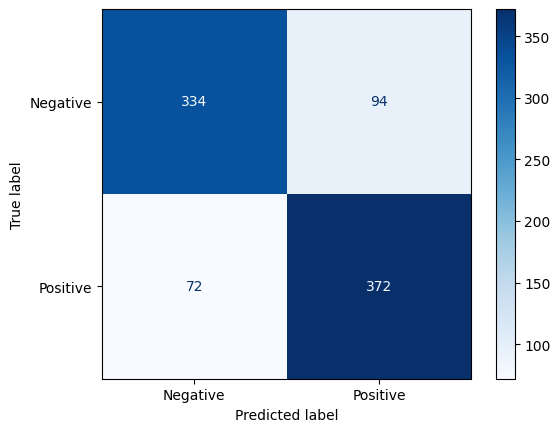

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

plot_confusion_matrix(y_dev, model.predict(X_dev))

## 67. 精度の計測

学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [11]:
from sklearn.metrics import classification_report

print("=== 学習データ ===")
print(classification_report(y_train,model.predict(X_train)))
print("=== 検証データ ===")
print(classification_report(y_dev, model.predict(X_dev)))

=== 学習データ ===
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     29780
           1       0.94      0.95      0.95     37569

    accuracy                           0.94     67349
   macro avg       0.94      0.94      0.94     67349
weighted avg       0.94      0.94      0.94     67349

=== 検証データ ===
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       428
           1       0.80      0.84      0.82       444

    accuracy                           0.81       872
   macro avg       0.81      0.81      0.81       872
weighted avg       0.81      0.81      0.81       872



## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [15]:
weights = model.coef_[0]    # 重みを取得
feature_names = vectorizer.get_feature_names_out()  # 特徴名を取得
sorted_indices = weights.argsort()[::-1]    # 降順(重みの高い順)にソート
top_n = 20

top_features = [(feature_names[i], weights[i]) for i in sorted_indices[:top_n]]
bottom_features = [(feature_names[i], weights[i]) for i in sorted_indices[-top_n:]]

print("=== Top 20 ===")
for feature, weight in top_features:
    print(f"{feature}: {weight:.4f}")

print("=== Bottom 20 ===")
for feature, weight in bottom_features:
    print(f"{feature}: {weight:.4f}")

=== Top 20 ===
refreshing: 3.4292
remarkable: 3.4256
powerful: 3.2187
hilarious: 3.1801
beautiful: 2.9978
wonderful: 2.9708
prose: 2.9476
terrific: 2.8677
appealing: 2.8550
enjoyable: 2.8158
treat: 2.7938
charmer: 2.7478
vividly: 2.7160
likable: 2.6944
solid: 2.6520
half-bad: 2.6344
fascinating: 2.6179
charming: 2.6169
impressive: 2.5958
intriguing: 2.5613
=== Bottom 20 ===
lousy: -2.9292
unfortunately: -2.9396
pointless: -2.9545
poor: -2.9837
none: -3.0200
hardly: -3.0270
squanders: -3.0427
lack: -3.0573
waste: -3.1541
loses: -3.1738
depressing: -3.2002
flat: -3.2226
bore: -3.2559
stupid: -3.3460
failure: -3.5830
mess: -3.6182
devoid: -3.6531
worst: -3.9779
lacks: -4.0779
lacking: -4.3339


## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

C:\Users\rerer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rerer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

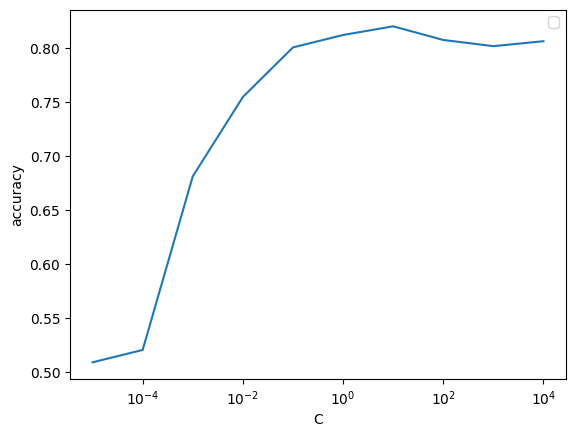

In [18]:
# 学習率：1e-5,1e-4,1e-3,0.01,0.1,1,10,100,1000,10000
C_list = [10**i for i in range(-5, 5)]

dev_accuracy = []

# 順番にモデルに学習させる
for C in C_list:
    model = LogisticRegression(C=C, random_state=42)
    model.fit(X_train, y_train)
    dev_accuracy.append(model.score(X_dev, y_dev))


plt.semilogx(C_list, dev_accuracy)
plt.xlabel("C")
plt.ylabel("accuracy")
plt.legend()
plt.show()